# Uncertainty Quantification for test cases

In [1]:
import os
import shutil

import numpy as np
from scipy.stats import norm,uniform,multivariate_normal

import UQLib.calibration.TMCMC as TMCMC
import UQLib.calibration.ABCSubSim as ABCSubSim
import test_cases.sinusoidal as sinusoidal
import test_cases.cosine as cosine

import matplotlib.pyplot as plt

seed = 1234
n_samples = 1000
modelpath = "/home/kevin/master_project/IUQ-Project/test_cases/cosine.py"

# Inverse UQ for a cosine function

## Exact Posterior sampling using the TMCMC algorithm

In [2]:
np.random.seed(seed)

# Generate data with Gaussian noise
x, y, y_err, true_params = cosine.generate(15,scale=0.01)
a, c, k, f = true_params

# Parameter names
model_params = ["a","c","k","f"]
error_params = ["error_boyz"]
design_vars = ["x"]

print("True parameter values:")
print(tuple(model_params), "=")
print((a,c,k,f))

# Design variable values
#design_vals = np.row_stack(np.broadcast(x,a,c))
design_vals = x

# Error parameter per design point
model_errors = ["error_boyz" for n in range(x.shape[0])]

# Define uniform prior wrapper functions and samplers for the model parameters
model_prior = lambda sample: np.prod([uniform.pdf(sample[n],-5.0,10.0) for n in range(len(model_params))])
model_sampler = lambda n_samples: np.random.uniform(-5.0,5.0,size=(n_samples,len(model_params)))

# Define prior wrapper function and sampler for the error parameter
error_prior = lambda sample: np.prod([uniform.pdf(sample[n],0.001,0.999) for n in range(len(error_params))])
error_sampler = lambda n_samples: np.random.uniform(0.001,1.0,size=(n_samples,len(error_params)))

# Construct problem dict
problem_ext = {"model_type":"external",
               "setup":(lambda params: cosine.setup(modelpath,params)),
               "measure":cosine.read_output,
               "model_params":model_params,
               "error_params":error_params,
               "design_vars":design_vars,
               "input_data":design_vals,
               "output_data":y,
               "data_errors":y_err,
               "error_mapping":model_errors,
               "model_prior":model_prior,
               "model_sampler":model_sampler,
               "error_prior":error_prior,
               "error_sampler":error_sampler
              }

problem_py = {"model_type":"python",
              "evaluate":cosine.evaluate_dict,
              "model_params":model_params,
              "error_params":error_params,
              "design_vars":design_vars,
              "input_data":design_vals,
              "output_data":y,
              "data_errors":y_err,
              "error_mapping":model_errors,
              "model_prior":model_prior,
              "model_sampler":model_sampler,
              "error_prior":error_prior,
              "error_sampler":error_sampler
              }

os.makedirs("TMCMC_output")
os.chdir("TMCMC_output")

df,qoi = TMCMC.sample(problem_py,n_samples,nprocs=8)

os.chdir("..")

# Remove garbage
shutil.rmtree("./TMCMC_output")

print(df)

True parameter values:
('a', 'c', 'k', 'f') =
(-3.084805496211077, 1.2210877103983186, -0.6227226099288554, 2.8535858371376923)
Running stage 0...
Current max likelihood: 3.948637773690772e-10
Calculating p for stage 1...
p: 1e-06
COV: 1.4484727938375628
Running stage 1...
Current max likelihood: 4.934183584940155e-12
Calculating p for stage 2...
p: 0.007823796403671684
COV: 0.9999998243274133
Running stage 2...
Current max likelihood: 4.934183584940155e-12
Calculating p for stage 3...
p: 0.03231135152367051
COV: 0.9999999123898853
Running stage 3...
Current max likelihood: 7.589704807883309e-05
Calculating p for stage 4...
p: 0.109880766752964
COV: 1.0000009416861024
Running stage 4...
Current max likelihood: 7.589704807883309e-05
Calculating p for stage 5...
p: 0.2101922857520844
COV: 1.0000033268164044
Running stage 5...
Current max likelihood: 0.00014923077560781756
Calculating p for stage 6...
p: 0.2957253354239457
COV: 0.9999996311707512
Running stage 6...
Current max likelihood:

### Propagate uncertainty forward to output

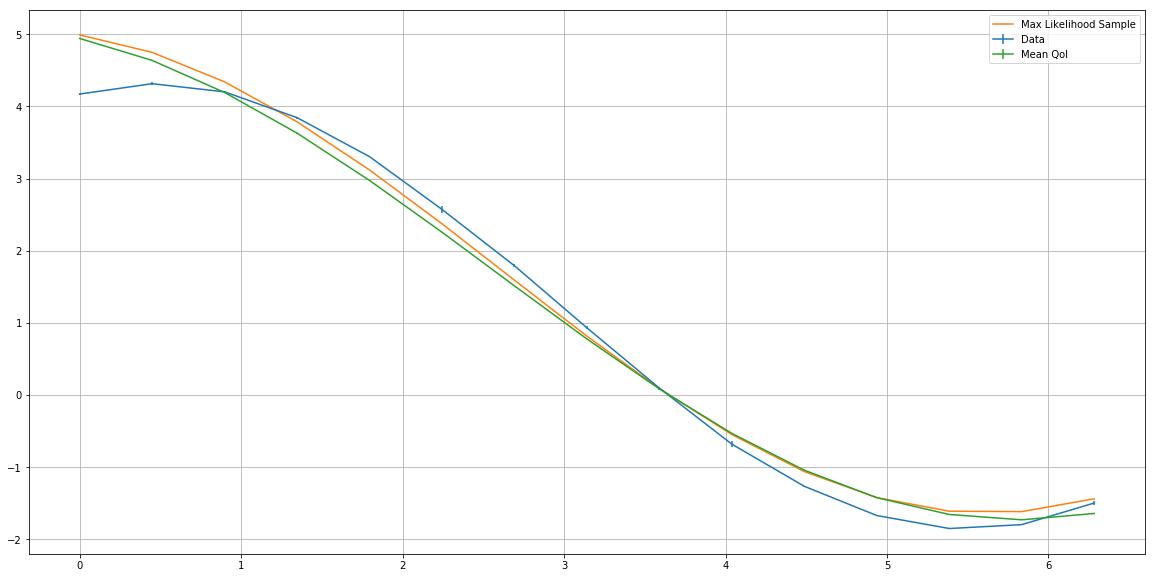

In [3]:
a,c,k,f = true_params

plt.figure(figsize=(20,10))
plt.grid(True)

# Data
plt.errorbar(x,y,yerr=y_err,label="Data")

# True values
interval = np.linspace(0,2*np.pi,1000)
y_true, _ = cosine.evaluate(interval,a,c,k,f)
#plt.plot(interval,y_true,label="True distribution")

# Highest likelihood
mle = np.argmax(df["likelihood"].values)
plt.plot(x,qoi[mle],label="Max Likelihood Sample")

# All distributions
#for n in range(qoi.shape[0]):
#    plt.plot(x,qoi[n])

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

plt.errorbar(x,mean,yerr=conf,label="Mean QoI")

plt.legend()

plt.show()

### Sanity check for output parity

In [4]:
for n in range(qoi.shape[0]):
    a,c,k,f = df.values[n,:4]
    remeasure_qoi,_ = cosine.evaluate(x,a,c,k,f)
    if (qoi[n] != remeasure_qoi).any():
        print("Difference:",qoi[n]-remeasure_qoi[n])

## Approximate Bayesian Computation (ABC) using Subset Simulation

In [5]:
def distance(a,b):
    return np.sqrt(np.sum((a-b)**2))

In [6]:
np.random.seed(seed)

# Generate data with Gaussian noise
x, y, y_err, true_params = cosine.generate(15,scale=0.01)
a, c, k, f = true_params

# Parameter names
model_params = ["a","c","k","f"]
design_vars = ["x"]

print("True parameter values:")
print(tuple(model_params), "=")
print((a,c,k,f))

# Design variable values
#design_vals = np.row_stack(np.broadcast(x,a,c))
design_vals = x

# Define uniform prior wrapper functions and samplers for the model parameters
param_prior = lambda sample: uniform.pdf(sample,-5.0,10.0)
param_sampler = lambda n_samples: np.random.uniform(-5.0,5.0,n_samples)

priors = [param_prior for param in model_params]
samplers = [param_sampler for param in model_params]

# Construct problem dict
problem_ext = {"model_type":"external",
               "setup":(lambda params: cosine.setup(modelpath,params)),
               "measure":cosine.read_output,
               "distance":distance,
               "model_params":model_params,
               "design_vars":design_vars,
               "input_data":design_vals,
               "output_data":y,
               "data_errors":y_err,
               "priors":priors,
               "samplers":samplers,
              }

problem_py = {"model_type":"python",
              "evaluate":cosine.evaluate_dict,
              "distance":distance,
              "model_params":model_params,
              "design_vars":design_vars,
              "input_data":design_vals,
              "output_data":y,
              "data_errors":y_err,
              "priors":priors,
              "samplers":samplers,
              }

os.makedirs("ABCSubSim_output")
os.chdir("ABCSubSim_output")

df,qoi = ABCSubSim.sample(problem_py,n_samples,nprocs=8,tol=0.5)

os.chdir("..")

# Remove garbage
shutil.rmtree("./ABCSubSim_output")

print(df)

True parameter values:
('a', 'c', 'k', 'f') =
(-3.084805496211077, 1.2210877103983186, -0.6227226099288554, 2.8535858371376923)
Initializing...
Running stage 1...
Current tolerance value: 12.12706996202016
Running stage 2...
Current tolerance value: 9.446707617324252
Running stage 3...
Current tolerance value: 6.3950650050797755
Running stage 4...
Current tolerance value: 3.1368201026456157
Running stage 5...
Current tolerance value: 1.5996264067107768
Running stage 6...
Current tolerance value: 0.9160822174190268
Running stage 7...
Current tolerance value: 0.5400338585045351
Running stage 8...
Current tolerance value: 0.2338197672582441
Minimum tolerance value reached
            a         c         k         f  distance
0   -3.080085  1.183146  0.611398 -2.865415  0.193951
1   -3.080085  1.183146  0.611398 -2.865415  0.193951
2   -3.080085  1.183146  0.611398 -2.865415  0.193951
3   -3.080085  1.183146  0.611398 -2.865415  0.193951
4   -3.080085  1.183146  0.611398 -2.865415  0.19395

### Propagate input uncertainty to output

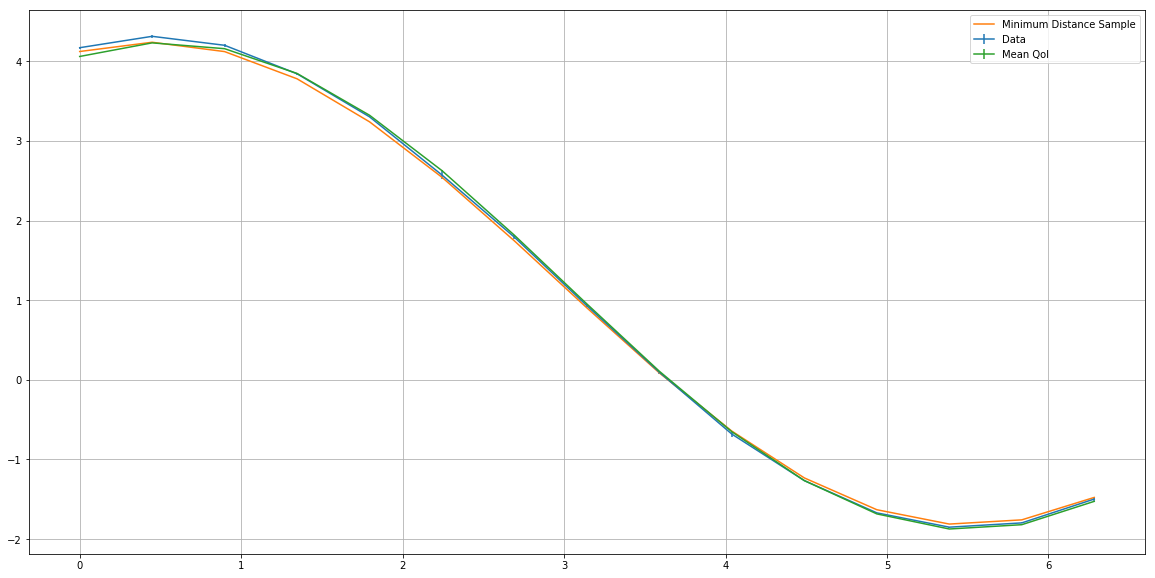

In [7]:
a,c,k,f = true_params

plt.figure(figsize=(20,10))
plt.grid(True)

# Data
plt.errorbar(x,y,yerr=y_err,label="Data")

# True values
interval = np.linspace(0,2*np.pi,1000)
y_true, _ = cosine.evaluate(interval,a,c,k,f)
#plt.plot(interval,y_true,label="True distribution")

# Highest likelihood
mde = np.argmin(df["distance"].values)
plt.plot(x,qoi[mde],label="Minimum Distance Sample")

# All distributions
#for n in range(qoi.shape[0]):
#    plt.plot(x,qoi[n])

# Mean QoI output
mean = np.mean(qoi,axis=0)
var = np.sum((qoi - mean[None,:])**2,axis=0) / (qoi.shape[0] - 1)
conf = 1.96 * np.sqrt(var / qoi.shape[0])

plt.errorbar(x,mean,yerr=conf,label="Mean QoI")

plt.legend()

plt.show()